In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import time

#### Plot layout
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette("tab10")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = False

# 09 Explicit 2D Heat with Cure

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2019_

> This notebook is strongly inspired by the notebooks of the online course _["Practical Numerical Methods with Python"](https://github.com/numerical-mooc/numerical-mooc/) by Lorena A. Barba et al_

## 2D Finite Difference Explicit Scheme for Heat Transfer

$$
c_p \frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = 
\frac{k_x}{\varrho} \frac{T^{n}_{i+1, j} - 2T^{n}_{i,j} + T^{n}_{i-1,j}}{\Delta x^2} +
\frac{k_y}{\varrho} \frac{T^{n}_{i, j+1} - 2T^{n}_{i,j} + T^{n}_{i,j-1}}{\Delta y^2}
+ q_{i, j}
$$

With:

$$
\Delta x = \Delta y = \Delta h
$$

$$
c_p \frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = 
\frac{k_x}{\varrho} \frac{T^{n}_{i+1, j} - 2T^{n}_{i,j} + T^{n}_{i-1,j}}{\Delta h^2} +
\frac{k_y}{\varrho} \frac{T^{n}_{i, j+1} - 2T^{n}_{i,j} + T^{n}_{i,j-1}}{\Delta h^2}
+ q_{i, j}
$$

$$
T^{n+1}_{i,j} =
T^n_{i,j} + \frac{ \Delta t}{c_p \varrho \Delta h^2} \left(
k_x (T^{n}_{i+1, j} - 2T^{n}_{i,j} + T^{n}_{i-1,j}) +
k_y (T^{n}_{i, j+1} - 2T^{n}_{i,j} + T^{n}_{i,j-1})
\right)
+ \frac{q_{i, j} \Delta t}{c_p \varrho}
$$

$$
T^{n+1}_{i,j} =
T^n_{i,j} + \frac{ \Delta t}{c_p \varrho \Delta h^2} \left(
k_x (T^{n}_{i+1, j} + T^{n}_{i-1,j}) +
k_y (T^{n}_{i, j+1} + T^{n}_{i,j-1})
- 2 (k_x + k_y) T^{n}_{i,j}
\right)
+ \frac{q_{i, j} \Delta t}{c_p \varrho}
$$

## RTM Mold Model

We simulate a quarter of a RTM tool (symmetric in both axis) with two plies with different fiber orientation but the same thickness $d_{ply}$. Left and lower boundary are set to the cure temperature (Dirichlet B.C.) and the right and top boundary have no heat flux (Neumann B.C.). 

<img src="./figures/Modell_full.png" width="600"/>

### Calculate thermal composite properties

In [2]:
# first create steel properties
rho_steel = 7850
c_steel = 475
k_steel = 50

# composite properties
phi = .6
CF = dict(k_f_parallel=10,
          k_f_perp=1.7,
          rho_f=1700,
          c_f=710) 
EP = dict(k_m=.21,
          rho_m=1110,
          c_m=1224)
material_data = {**CF, **EP}

c_f = material_data["c_f"]
rho_f = material_data["rho_f"]
c_m = material_data["c_m"]
rho_m = material_data["rho_m"]
k_f_perp = material_data["k_f_perp"]
k_f_parallel = material_data["k_f_parallel"]
k_m = material_data["k_m"]

c_comp = (c_f * rho_f * phi + c_m * rho_m * (1 - phi)) / (rho_f * phi + rho_m * (1 - phi))
print("c_comp =", c_comp)

# k perpendicular to fibers
k_comp_perp = 1 / (phi / k_f_perp * phi + (1 - phi) / k_m)
print("k_comp_perp =", k_comp_perp)
k_comp_parallel = k_f_parallel * phi + k_m * (1 - phi)
print("k_comp_parallel =", k_comp_parallel)

rho_comp = rho_f * phi + rho_m * (1 - phi)
print("rho_comp =", rho_comp)

psi_comp = rho_f * phi / (rho_f * phi + rho_m * (1 - phi))
print("psi_comp =", psi_comp)

c_comp = 865.8852459016393
k_comp_perp = 0.47247220751720487
k_comp_parallel = 6.084
rho_comp = 1464.0
psi_comp = 0.6967213114754098


### Cure Model

In [3]:
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def reaction_model(X, temp, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    k1, k2 = arrhenius_facors(temp, model_parameters)
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = max_X - X
    d_X[d_X < 0] = 0
    return k1 * d_X**l + k2 * X**m * d_X**n
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])


Hein_2018 = dict(Tg0=-16.8, Tg8=225, lam=.543,    # DiBenedetto
                a=.04, b=3.93,                    # X_max
                A1=np.exp(11.149), EA1=75549,     # Cure model parameters
                A2=np.exp(8.762), EA2=50911, 
                l=.489, m=1.549, n=2.179,
                Hr=490e3                         # Enthalpy [J / kg]
                )
#### Constants
kelvin = 273.15
R = 8.314472

### Discretize space

In [4]:
# dh = dx = dy
dh = 1/1000
d_mold = 15/1000
w_mold = 20/1000
d_ply = 8/1000
w_ply = 80/1000

d_tot = d_mold + 2 * d_ply
w_tot = w_mold + w_ply

print("physical domain size [m^2] = %f x %f" %(d_tot, w_tot))

Nx = int((w_tot) / dh)
Ny = int((d_tot) / dh)

print("Nx =", Nx)
print("Ny =", Ny)
shape = (Ny, Nx)

# shift coordinates half a step (element not material interface)
x = (np.arange(Nx) + .5) * dh
y = (np.arange(Ny) + .5) * dh  
xx, yy = np.meshgrid(x, y)

# make indexes of materials (boolean arrays)
idx_mold = (xx <= w_mold) | (yy <= d_mold)
idx_comp = (xx > w_mold) & (yy > d_mold)
idx_ply_1 = idx_comp & (yy <= d_mold + d_ply)
idx_ply_2 = idx_comp & (yy > d_mold + d_ply)

# Dirichlet BC (set T_cure value)
idx_BC = np.zeros(shape, dtype=np.bool)
idx_BC[:] = False
idx_BC[0, :] = True
idx_BC[:, 0] = True

# assign properties
cp = np.zeros(shape)
cp[idx_mold] = c_steel
cp[idx_comp] = c_comp

rho = np.zeros(shape)
rho[idx_mold] = rho_steel
rho[idx_comp] = rho_comp

kx = np.zeros(shape)
ky = np.zeros(shape)
kx[idx_mold] = k_steel
ky[idx_mold] = k_steel
ky[idx_comp] = k_comp_perp
kx[idx_ply_2] = k_comp_perp
kx[idx_ply_1] = k_comp_parallel

alpha_x = kx / cp / rho
alpha_y = ky / cp / rho

physical domain size [m^2] = 0.031000 x 0.100000
Nx = 100
Ny = 31


<IPython.core.display.Javascript object>


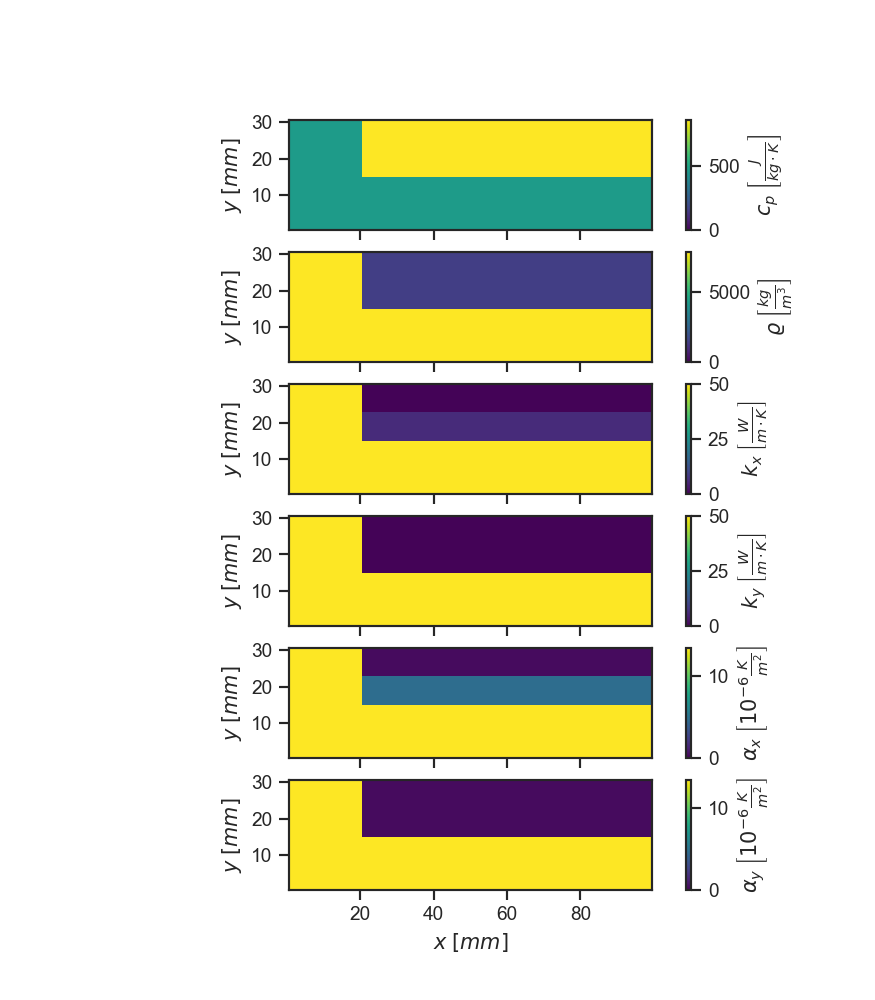

In [5]:
imshow_extent=[x[0]*1000, x[-1]*1000, y[0]*1000, y[-1]*1000]

labels = [r"c_p", r"\varrho", r"k_x", r"k_y", r"\alpha_x", r"\alpha_y"]
units = [r"\frac{J}{kg \cdot K}", r"\frac{kg}{m^3}"]
units += 2* [r"\frac{W}{m \cdot K}"]
units += 2* [r"10^{-6} \frac{K}{m^2}"]

fig, ax = plt.subplots(6, 1, sharex=True, sharey=True, figsize=[7, 8])

for i, data in enumerate([cp, rho, kx, ky, alpha_x*1e6, alpha_y*1e6]):
    plt.sca(ax[i])
    p = plt.imshow(data, cmap="viridis", aspect="equal", vmin=0, origin="lower", 
              extent=imshow_extent)
    label = r"$%s \; \left[ %s \right]$" %(labels[i], units[i])
    plt.colorbar(p, label=label)
    plt.ylabel(r"$y \; [mm]$")
plt.xlabel(r"$x \; [mm]$");

## Time discretization

In [6]:
# CFL criterion
alpha_max = np.max([np.max(_alpha) for _alpha in [alpha_x, alpha_y]])
print(cp.max())
print(rho.max())
print(kx.min())
print(alpha_max)

dt_CFL = dh**2 / alpha_max / 4
print("limit for numerical stability: dt =", dt_CFL, "s")
dt = dt_CFL * .8
print("used time step: dt =", dt, "s")

t_max = 3*3600
print("t_max =", t_max)
Nt = int(t_max / dt + 1) 
print("Nt =", Nt)
t = np.arange(Nt) * dt

# Set temperature cycle
T_cure = 160
cycle = [[0, T_cure]]
cycle.append([t_max, T_cure]) 
cycle = np.array(cycle)

865.8852459016393
7850.0
0.47247220751720487
1.340931947703654e-05
limit for numerical stability: dt = 0.01864375 s
used time step: dt = 0.014915000000000001 s
t_max = 10800
Nt = 724104


### Simulate!

i_snap = 72410


<IPython.core.display.Javascript object>


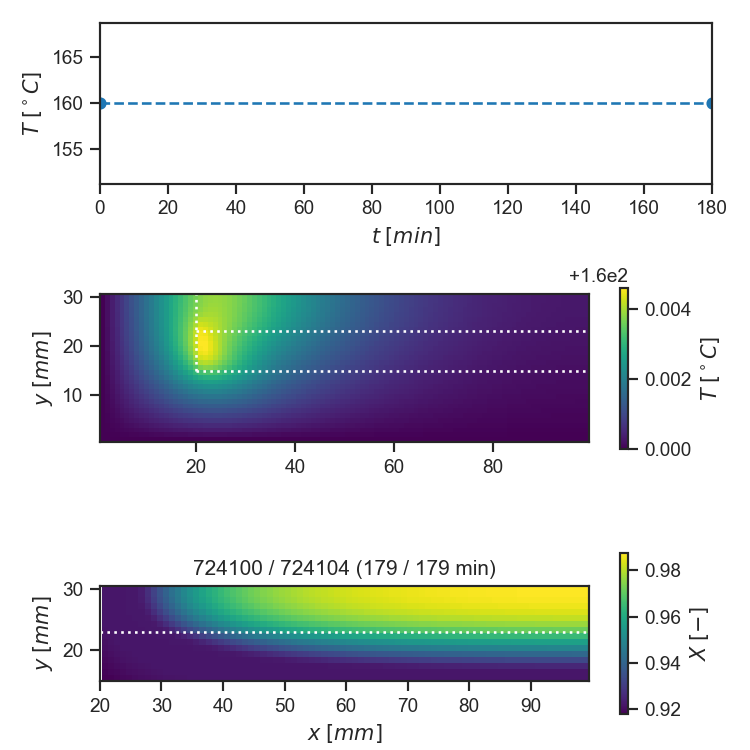

In [7]:
# Set initial conditions
T = np.zeros(shape)
T[:] = cycle[0, 1]

# degree of cure
X = np.zeros(shape)
X[idx_mold] = np.nan

# choose how often to update plot
i_snap = Nt // 10
print("i_snap =", i_snap)

### prepare output arrays
# 1st column: max temp and X in composite
# 2nd column: min temp and X in composite
T_out = np.zeros((Nt, 2))
X_out = np.zeros((Nt, 2))

# prepare plot
fig_sim, ax = plt.subplots(3, 1, figsize=[6, 6])
ax1, ax2, ax3 = ax
line_kw = dict(marker="o", ls="--")

plt.sca(ax1)
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1], **line_kw)
p_cycle = plt.axvline(cycle[0, 0]/60, ls=":", color="k")


plt.sca(ax2)
plt.ylabel(r"$T \; [ ^\circ C ]$")
p_temp = plt.imshow(T, cmap="viridis", aspect="equal", origin="lower", 
              extent=imshow_extent)
cb_temp = plt.colorbar(p_temp, label=r"$T \; [ ^\circ C ]$")

plt.sca(ax3)
plt.ylabel(r"$X \; [ - ]$")
p_cure = plt.imshow(X, cmap="viridis", aspect="equal", origin="lower", 
              extent=imshow_extent)
cb_cure = plt.colorbar(p_cure, label=r"$X \; [ - ]$")
plt.xlabel(r"$x \; [mm]$")

edge_kw = dict(ls=":", color="w")
for _ax in ax[1:]:
    # plot material domain borders
    _ax.plot([w_mold*1000]*2, [d_mold*1000, y[-1]*1000], **edge_kw)
    _ax.plot([w_mold*1000, x[-1]*1000], [d_mold*1000]*2, **edge_kw)
    _ax.plot([w_mold*1000, x[-1]*1000], [(d_mold + d_ply)*1000]*2, **edge_kw)
    
    _ax.set_ylabel(r"$y \; [mm]$")
    
ax1.autoscale(axis="x", tight=True)

# Show only composite area for degree of cure
ax3.set_xlim([w_mold*1000, None])
ax3.set_ylim([d_mold*1000, None])

plt.tight_layout(pad=0)
plt.ion();

In [8]:
use_numba = False
if use_numba:
    from numba import jit
    
    @jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
    def heat_transfer_numba(T, dt, cp, rho, dh, kx, ky):
        ni, nj = np.shape(T)
        dT = np.zeros((ni-2, nj-2))
        for j in range(1, nj-1):
            for i in range(1, ni-1):
                dT[i-1, j-1] = 1 / cp[i, j] / rho[i,j]  * \
                              (kx[i, j] * (T[i+1, j] + T[i-1, j]) +\
                               ky[i, j] * (T[i, j+1] + T[i, j-1]) - \
                               2 * (kx[i, j] + ky[i, j]) * T[i, j])
        T[1:-1, 1:-1] += dT*dt / dh**2
        return T

    
t0 = time.time()
for n in range(Nt):
    # Left and Lower Boundary: set value from temperate cycle 
    T[idx_BC] = interpol_tempcycle(t[n], cycle)
    
    # calculate heat transfer
    if use_numba:
        T = heat_transfer_numba(T, dt, cp, rho, dh, kx, ky)
    else:
        T[1:-1, 1:-1] = T[1:-1, 1:-1] + \
                        dt / cp[1:-1, 1:-1] / rho[1:-1, 1:-1] / dh**2 * \
                        (kx[1:-1, 1:-1] * (T[2:, 1:-1] + T[:-2, 1:-1]) +\
                         ky[1:-1, 1:-1] * (T[1:-1, 2:] + T[1:-1, :-2]) - \
                         2 * (kx[1:-1, 1:-1] + ky[1:-1, 1:-1]) * T[1:-1, 1:-1])
    
    # reaction rate
    dXdt = reaction_model(X[idx_comp], T[idx_comp], Hein_2018)
    # update degree of cure
    X[idx_comp] += dXdt*dt

    # released heat
    q = dXdt*dt*Hein_2018["Hr"]*(1-psi_comp)    
    T[idx_comp] += q/cp[idx_comp]
    
    # right boundary condition (no heat flux)
    T[:, -1] = T[:, -2]
    # upper boundary condition (no heat flux)
    T[-1, :] = T[-2, :]
    
    # write output
    T_out[n, 0] = T[idx_comp].max()
    T_out[n, 1] = T[idx_comp].min()
    X_out[n, 0] = X[idx_comp].max()
    X_out[n, 1] = X[idx_comp].min()
    
    # update plot
    if n % i_snap == 0:
        ax3.set_title("%d / %d (%d / %d min)" %(n, Nt, t[n]/60, t[-1]/60))
        p_cycle.set_xdata(t[n]/60)        
        p_temp.set_data(T)
        p_cure.set_data(X)    
        T_range = [T.min(), T.max()]
        p_temp.set_clim(T_range)
        p_cure.set_clim(X[idx_comp].min(), X[idx_comp].max())
        fig_sim.canvas.draw()
t1 = time.time() - t0
print("elapsed time =", t1)
print("time / iteration =", t1 / Nt)
print("iterations / s =", Nt / t1)

# on my laptop
# no numba: 208s
# numba: 178s

elapsed time = 177.61999988555908
time / iteration = 0.00024529625562841675
iterations / s = 4076.7030766047833


### Postprocessing

T_max = 245.00638871715694


<IPython.core.display.Javascript object>


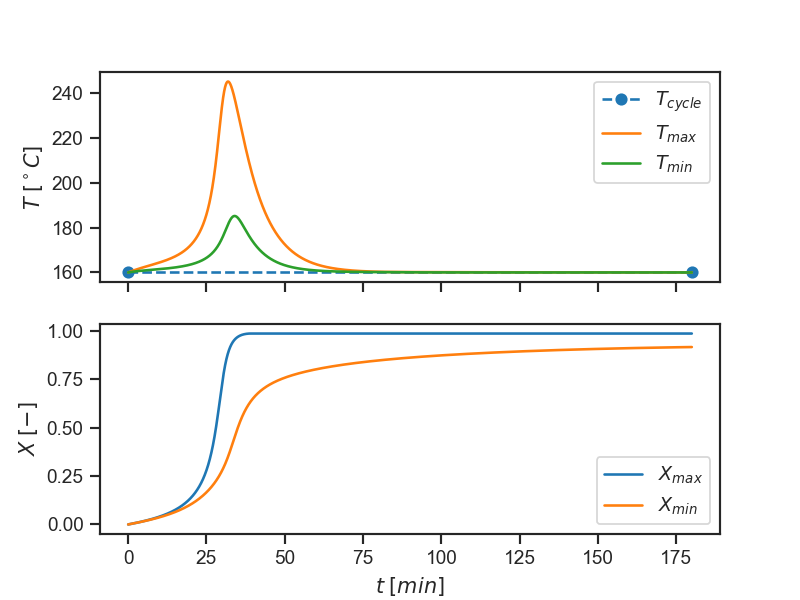

In [9]:
print("T_max =", T_out[:, 0].max())

fig, ax = plt.subplots(2, 1, sharex=True)
ax1, ax2 = ax
ax1.plot(cycle[:, 0]/60, cycle[:, 1], "o--", label=r"$T_{cycle}$")

for i, _label in enumerate(["max", "min"]):
    plt.sca(ax1)
    label = r"$T_{%s}$" %_label
    plt.plot(t/60, T_out[:, i], label=label)
    plt.sca(ax2)
    label = r"$X_{%s}$" %_label
    plt.plot(t/60, X_out[:, i], label=label)

for _ax in ax:
    _ax.legend()

ax1.set_ylabel(r"$T \; [ ^\circ C ]$")
ax2.set_ylabel(r"$X \; [ - ]$")
ax2.set_xlabel(r"$t \; [min]$")

plt.sca(ax3)

plt.tight_layout();

<IPython.core.display.Javascript object>


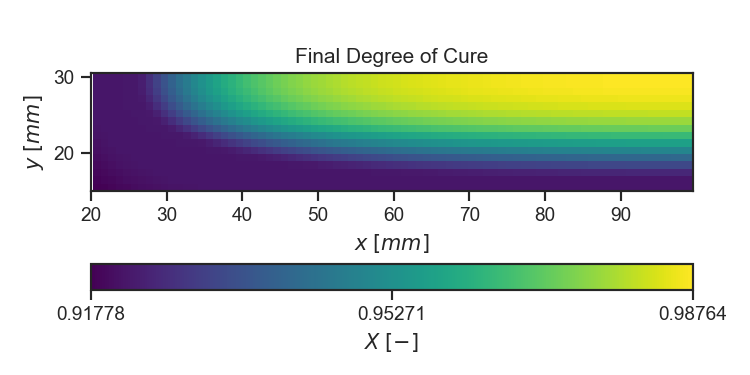

In [10]:
gs = plt.GridSpec(6, 1)

fig = plt.figure(figsize=[6, 3])
ax1 = fig.add_subplot(gs[:-1, :])
plt.title("Final Degree of Cure")

vmin = np.min(X[idx_comp])
vmax = np.max(X[idx_comp])
p_cure = plt.imshow(X, cmap="viridis", aspect="equal", origin="lower", vmin=vmin, vmax=vmax, 
              extent=imshow_extent)
plt.xlim([w_mold*1000, None])
plt.ylim([d_mold*1000, None])
plt.xlabel(r"$x \; [mm]$")    
plt.ylabel(r"$y \; [mm]$")

ax2 = fig.add_subplot(gs[-1, :])
cb_cure = plt.colorbar(p_cure, ax2, label=r"$X \; [ - ]$", ticks=np.linspace(vmin, vmax, 3),
                      orientation="horizontal")

plt.tight_layout();